In [215]:
import dask.dataframe as dd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
from joblib import Parallel, delayed
parquet_file_path = 'SimulationResults/UltimateAnalysis/SimulationResults_1750670687/SimulationResults_1750670687.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/SimulationResults_1750670687/SimulationResults_1750670687.pickle'

In [220]:
def analyze_matrix(pickle_data):
    matrix_phages = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
    matrix_bacteria = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
    
    def process_resource(i, r_matrix_value):
        print("querying on r_matrix_value=", r_matrix_value)
        ddf = dd.read_parquet(
            parquet_file_path,
            engine='pyarrow',
            include_partition_columns=True,
            gather_statistics=True,
            dtype_backend='pyarrow',
            filters=[("tau_vector", "==", str(r_matrix_value))]
        )
        bacteria_survivability = np.zeros(len(pickle_data['param_values_list_combination'][1]))
        phage_survivability = np.zeros(len(pickle_data['param_values_list_combination'][1]))

        for j, e_matrix_value in enumerate(pickle_data['param_values_list_combination'][1]):
            simulation_results = ddf.query(f"r_matrix == {e_matrix_value}").compute()
            y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[:, :]
            uninfected_bacteria_last_value_extracted = y_values[pickle_data['agent_type_count'][0]:pickle_data['agent_type_count'][0] + pickle_data['agent_type_count'][1]]
            bacteria_sum = 0
            for bacteria in uninfected_bacteria_last_value_extracted:
                if bacteria[-1] > 1:
                    bacteria_sum += 1
            phage_last_value_extracted = y_values[pickle_data['agent_type_count'][0]+pickle_data['agent_type_count'][1]+pickle_data['agent_type_count'][2]:pickle_data['agent_type_count'][0]+pickle_data['agent_type_count'][1]+pickle_data['agent_type_count'][2]+pickle_data['agent_type_count'][3]]
            phage_sum = 0
            for phage in phage_last_value_extracted:
                if phage[-1] > 1:
                    phage_sum += 1
            phage_survivability[j] = phage_sum
            bacteria_survivability[j] = bacteria_sum
        return phage_survivability, bacteria_survivability

    results = Parallel(n_jobs=-1)(
        delayed(process_resource)(i, resource_value)
        for i, resource_value in enumerate(pickle_data['param_values_list_combination'][0])
    )

    for i, result in enumerate(results):
        col1, col2 = result
        matrix_phages[i, :] = col1
        matrix_bacteria[i, :] = col2
    return matrix_phages.T, matrix_bacteria.T

In [223]:
def create_plot(matrix_phages, matrix_bacteria, pickle_data, save_fig=None):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    for i, matrix in enumerate([matrix_phages, matrix_bacteria]):
        xtick_indices = np.arange(len(pickle_data['param_values_list_combination'][0]), step=5)
        ytick_indices = np.arange(len(pickle_data['param_values_list_combination'][1]), step=5)
        xtick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][0])[xtick_indices]]
        ytick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][1])[ytick_indices]]

        ax[i].imshow(matrix, cmap='viridis', aspect='auto', interpolation='nearest')

        ax[i].set_xlabel(r'$\tau$ values', fontsize=16)
        ax[i].set_ylabel(r'$\beta$ values', fontsize=16)
        ax[i].set_xticks(xtick_indices)
        ax[i].set_xticklabels(xtick_labels, fontsize=8, rotation=-90)
        ax[i].set_yticks(ytick_indices)
        ax[i].set_yticklabels(ytick_labels, fontsize=8)
        ax[i].set_title(['Phage Survivability', 'Uninfected + Infected Bacteria Survivability'][i], fontsize=16)
        cax = ax[i].imshow(matrix, cmap='viridis', aspect='auto')
        # Set color limits for each subplot individually
        cax.set_clim(0, 20)

        plt.colorbar(cax, ax=ax[i], orientation='vertical', fraction=0.02, pad=0.04, label='Count')
    plt.suptitle(r'Number of Phages and Bacteria That Survived in a Large $20\times20\times10$ System', fontsize=20)
    # Remove individual colorbars and create a single shared colorbar
    plt.tight_layout()
    if save_fig is not None:
        plt.savefig(f'LatexReport/Images/Plots/Created/{save_fig}', dpi=300, bbox_inches='tight')
    plt.show()

parameter_names_used ['tau_vector', 'r_matrix']
param_values_list_combination [[0.5, 0.5769230769230769, 0.6538461538461539, 0.7307692307692308, 0.8076923076923077, 0.8846153846153846, 0.9615384615384616, 1.0384615384615385, 1.1153846153846154, 1.1923076923076923, 1.2692307692307692, 1.3461538461538463, 1.4230769230769231, 1.5, 1.576923076923077, 1.653846153846154, 1.7307692307692308, 1.8076923076923077, 1.8846153846153846, 1.9615384615384617, 2.0384615384615383, 2.1153846153846154, 2.1923076923076925, 2.269230769230769, 2.3461538461538463, 2.4230769230769234, 2.5, 2.576923076923077, 2.653846153846154, 2.730769230769231, 2.807692307692308, 2.8846153846153846, 2.9615384615384617, 3.0384615384615388, 3.1153846153846154, 3.1923076923076925, 3.269230769230769, 3.3461538461538463, 3.4230769230769234, 3.5], [0.001, 0.006102564102564103, 0.011205128205128204, 0.016307692307692308, 0.02141025641025641, 0.026512820512820515, 0.031615384615384615, 0.03671794871794872, 0.04182051282051282, 0.0469

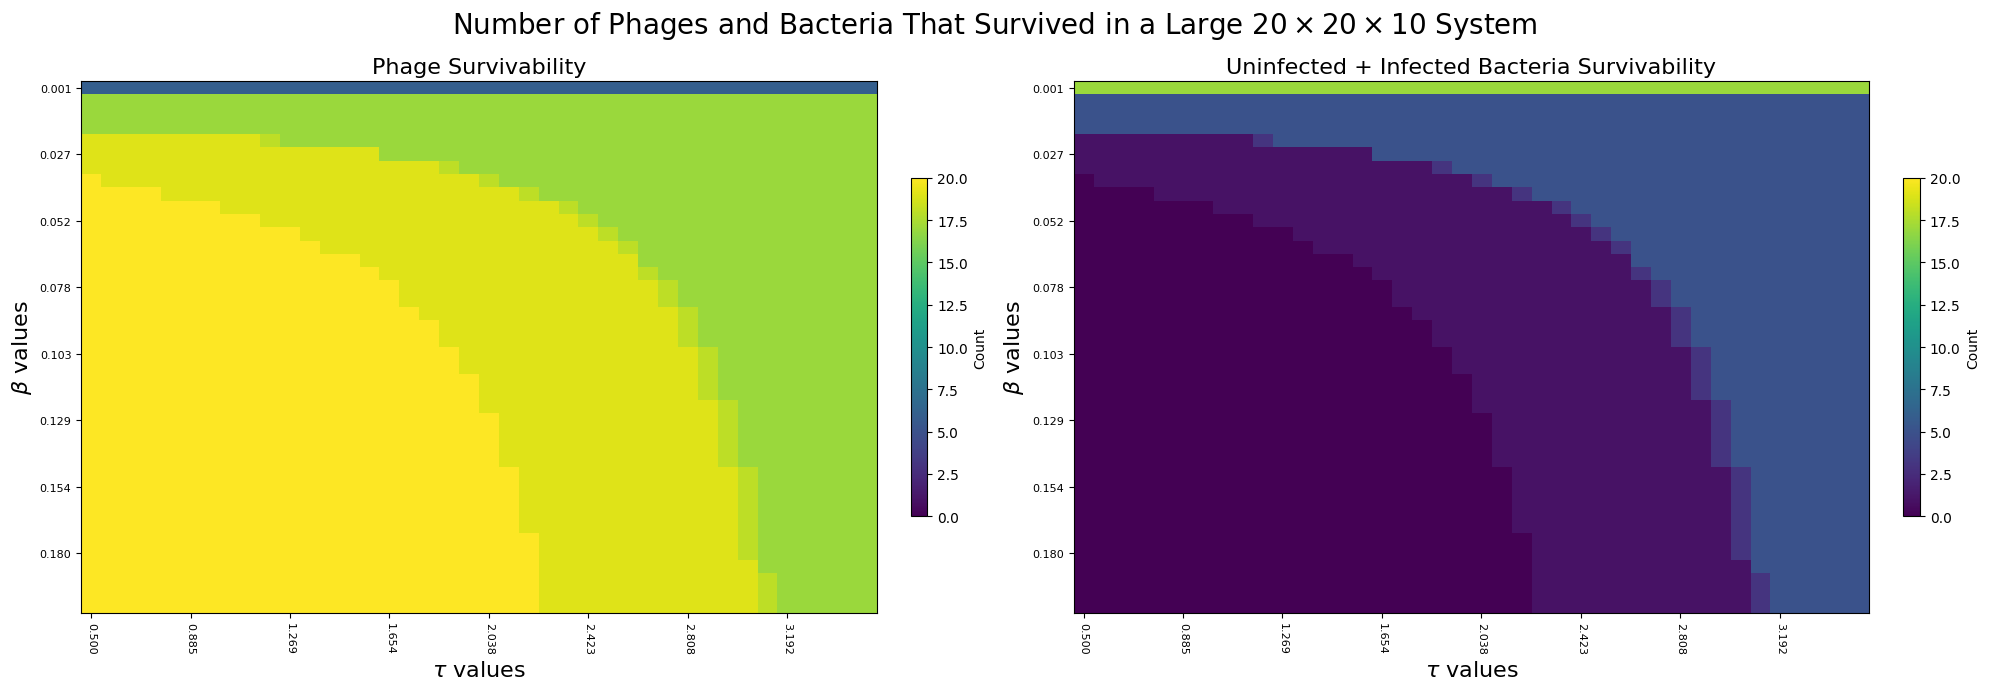

In [ ]:
with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])
print(pickle_data['environment_data'])

matrix_phages, matrix_bacteria = analyze_matrix(pickle_data)
np.set_printoptions(threshold=np.inf)
create_plot(matrix_phages, matrix_bacteria, pickle_data, save_fig='phage_bacteria_survivability.png')
# )